In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################

#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725

import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb

In [2]:
t1=time.time()

# Select an observation block and load basic information in


In [3]:
#select an observation block

#fname='1551037708'  #3c237 
#fname='1551055211'  #rfi
#fname='1553966342'  #rfi #PicA
#fname='1554156377'  #diode noise in one dump ##rfi clean
fname='1556138397'  #rfi spots structure, only one so ok
#fname='1555775533'  #vis<1 and structure #PicA
#fname='1555793534'  #vis<1 and rfi pollution
#fname='1556120503'  #strong rfi spots in line #PicA
#fname='1556052116'  #good one, vis < 10
#fname='1556034219'  #vis<10 #strong rfi spots in line #PicA
#fname='1555879611'  #vis=0 problem
#fname='1555861810'  #vis=0 problem #PicA
#fname='1561650779'  #diode shift
#fname='1558464584'  #3C273 track #diode shift
#fname='1558472940'  #3C273 track #diode shift
#fname='1562857793'

In [4]:
data=kio.load_data(fname)
print data
#print data.obs_script_log

Name: file:///idia/projects/hi_im/SCI-20190418-MS-01/1556138397/1556138397/1556138397_sdp_l0.full.rdb | 1556138397-sdp-l0 (version 4.0)
Observer: MarioSantos  Experiment ID: 20190424-0026
Description: 'Constant elevation scan with noise diode pattern'
Observed from 2019-04-24 22:40:11.470 SAST to 2019-04-25 00:45:12.296 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m008,m009,m010,m011,m012,m013,m015,m016,m018,m019,m020,m021,m022,m023,m024,m025,m026,m027,m028,m029,m030,m031,m033,m034,m035,m036,m037,m038,m039,m040,m043,m044,m045,m046,m047,m048,m049,m050,m051,m052,m053,m054,m055,m056,m058,m059,m060,m061,m062,m063  116      6844
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.984
-------------------------------------------------------------------------

In [5]:
#show the calibrator and bad ants information
target,c0,bad_ants,flux_model=kio.check_ants(fname)


calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
bad_ants: ['m014', 'm015', 'm016', 'm017', 'm024', 'm032', 'm033', 'm041', 'm042', 'm057', 'm059']


In [6]:
#show ants which have data 
print kio.ant_list(data)

['m000' 'm001' 'm002' 'm003' 'm004' 'm005' 'm006' 'm007' 'm008' 'm009'
 'm010' 'm011' 'm012' 'm013' 'm015' 'm016' 'm018' 'm019' 'm020' 'm021'
 'm022' 'm023' 'm024' 'm025' 'm026' 'm027' 'm028' 'm029' 'm030' 'm031'
 'm033' 'm034' 'm035' 'm036' 'm037' 'm038' 'm039' 'm040' 'm043' 'm044'
 'm045' 'm046' 'm047' 'm048' 'm049' 'm050' 'm051' 'm052' 'm053' 'm054'
 'm055' 'm056' 'm058' 'm059' 'm060' 'm061' 'm062' 'm063']


# Select ant and polarization, then load data in 

In [7]:
#select ant, polarization, and one channel to show data calibration
ant='m000'
pol='v'
ch_plot=800


In [8]:
#load data, labels, and parameters
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print corr_id,recv
vis,flags= kio.call_vis(fname,recv)
vis_backup=vis.copy()
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
nd_set,nd_time,nd_cycle,nd_ratio=kio.load_ndparam(fname,data)
dp_tt,dp_ss,dp_f,dp_t,dp_s=kl.label_dump_1ch(data,ant,pol,flags,ch_plot)
dp_w=kl.select_waste(data,ant,pol)
assert(np.shape(data)[2]==1)
dp_sb=dp_ss[0]
dp_se=dp_ss[-1]
ang_deg=kio.load_ang_deg(ra,dec,c0)
p_radec=np.loadtxt('radio_source.txt')

0 m000v
['m000v' 'm000v']


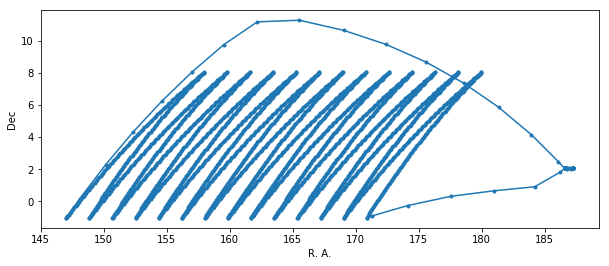

In [9]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra,dec,'.-')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

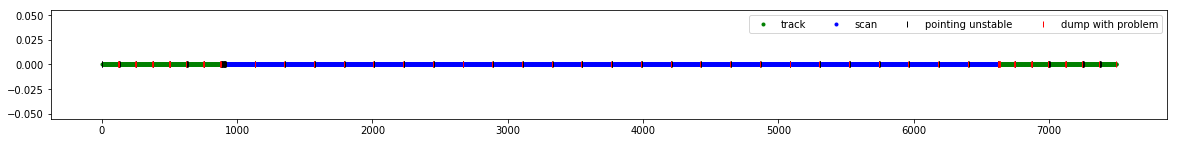

In [10]:
#show time dump label along the scan 
plt.figure(figsize=(20,2))
plt.plot(timestamps[dp_tt]-timestamps[0],np.zeros_like(dp_tt),'g.')
plt.plot(timestamps[dp_ss]-timestamps[0],np.zeros_like(dp_ss),'b.')
plt.plot(timestamps[dp_w]-timestamps[0],np.zeros_like(dp_w),'k|')
plt.plot(timestamps[dp_f]-timestamps[0],np.zeros_like(dp_f),'r|')
plt.legend(['track','scan','pointing unstable','dump with problem'],ncol=4)
plt.show()

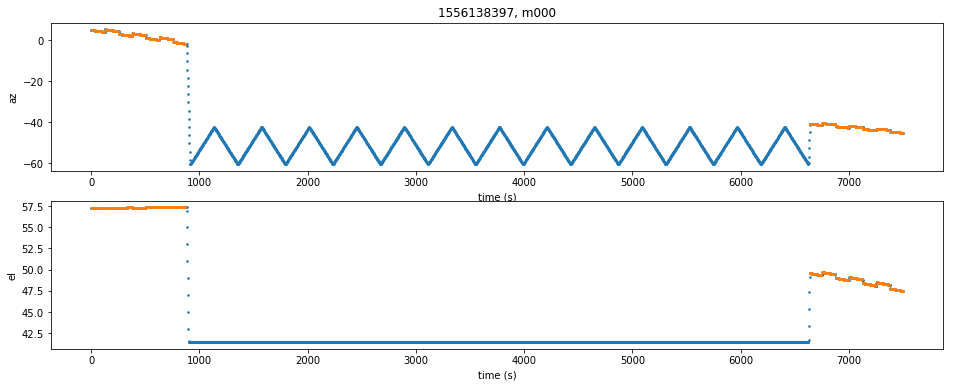

In [11]:
#show the az,el along time
plt.figure(figsize=(16,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps-timestamps[0],az,'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],az[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('az')
plt.title(str(fname)+', '+str(ant))
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps-timestamps[0],el,'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],el[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf')
plt.show()

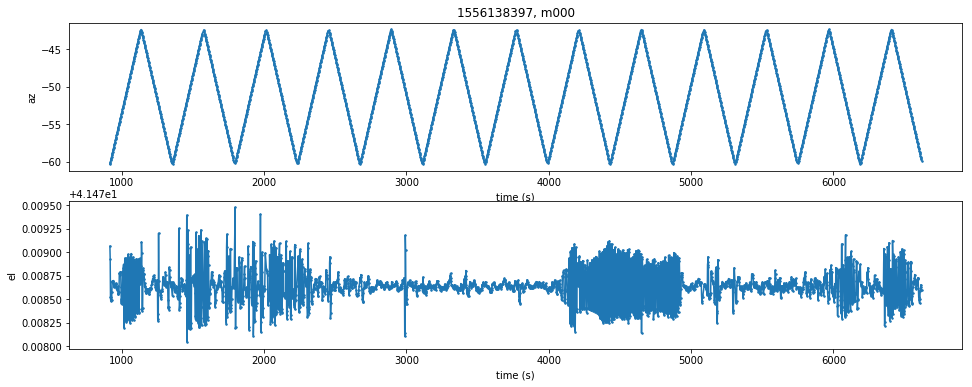

In [12]:
#az,el for scan part, which are expected to be stable
plt.figure(figsize=(16,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],az[dp_ss],'.-',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('az')
plt.title(str(fname)+', '+str(ant))
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],el[dp_ss],'.-',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf')
plt.show()

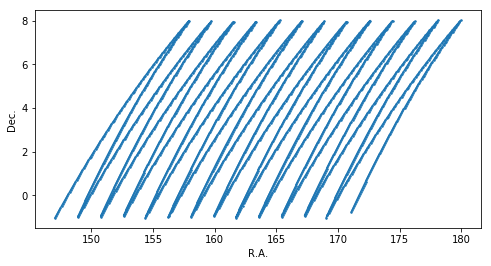

In [13]:
#sky coverage in scan part
plt.figure(figsize=(8,4))
if ant not in bad_ants:
    plt.plot(ra[dp_ss],dec[dp_ss],'.-',Markersize=3)
plt.xlabel('R.A.')
plt.ylabel('Dec.')
plt.show()

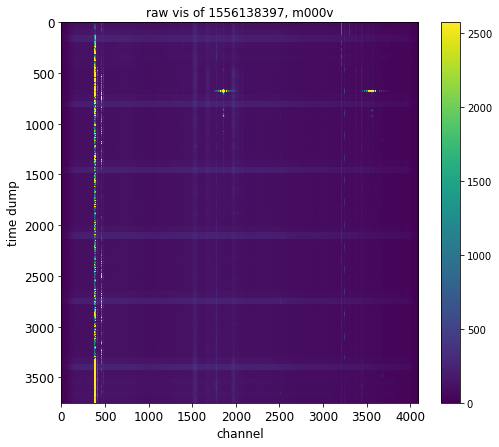

In [14]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(vis,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time dump',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('raw vis of '+str(fname)+', '+str(recv),fontsize=12)
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

In [15]:
#read noise diode labels in 
t_line=kd.cal_t_line(fname, timestamps,nd_set, nd_cycle, data.dump_period)
#mark,nd_1_det,nd_1a_det,nd_1b_det,lmin,lmax=kd.label_nd_injection(fname,vis, timestamps, dp_ss, data.dump_period)
nd_1a,nd_1b,nd_1,nd_0=kd.call_nd_1_list(fname,timestamps)
nd_s1a,nd_s1b,nd_s1,nd_s0=kd.cal_nds_list(dp_ss,nd_1a,nd_1b,nd_1,nd_0)#dp_ss here, not dp_s
nd_t1a,nd_t1b,nd_t1,nd_t0=kd.cal_ndt_list(dp_tt,nd_1a,nd_1b,nd_1,nd_0)#dp_tt here, not dp_t
nd_labels=nd_s1a,nd_s1b,nd_s1,nd_s0,nd_t1a,nd_t1b,nd_t1,nd_t0
nd_label0=dp_s,dp_t,nd_1a,nd_1b,nd_1,nd_0 ###only for rfi flagging

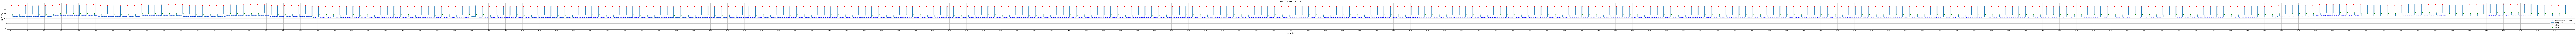

In [16]:
#noise diode injection along time ***plot is very long***
ch_plot0=800
plt.figure(figsize=(np.shape(timestamps)[0]*0.1,4))
plt.plot(timestamps-timestamps[0],(vis[:,ch_plot0]),'b.')
plt.step(timestamps-timestamps[0],(vis[:,ch_plot0]),'-',where='mid')
plt.plot(timestamps[nd_1a]-timestamps[0],(vis[nd_1a,ch_plot0]),'ro')
plt.plot(timestamps[nd_1b]-timestamps[0],(vis[nd_1b,ch_plot0]),'go')
plt.xlabel('time (s)',fontsize=18)
plt.legend(['vis @ timestamps centre','dump edge','nd_1a','nd_1b'],fontsize=12)
plt.ylabel('raw_vis',fontsize=18)
plt.title('obs'+str(fname)+', '+str(recv),fontsize=14)
plt.xlim(-10,timestamps[-1]-timestamps[0]+10)
plt.xticks(np.arange(0,timestamps[-1]-timestamps[0]+1, 50))
plt.grid()
plt.show()

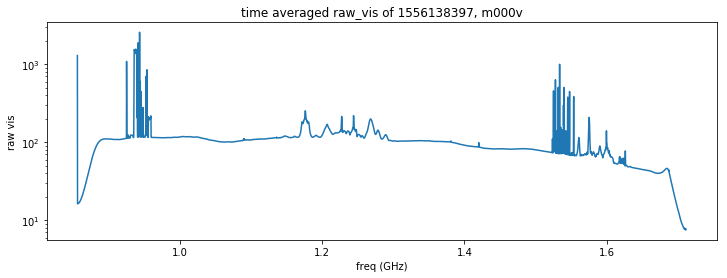

In [17]:
##time mean raw vis to show the bandpass
plt.figure(figsize=(12,4))
plt.plot(freqs/1e9,np.mean(vis[nd_0,:],axis=0))
plt.xlabel('freq (GHz)')
plt.ylabel('raw vis')
plt.yscale('log')
plt.title('time averaged raw_vis of '+str(fname)+', '+str(recv))
plt.show()

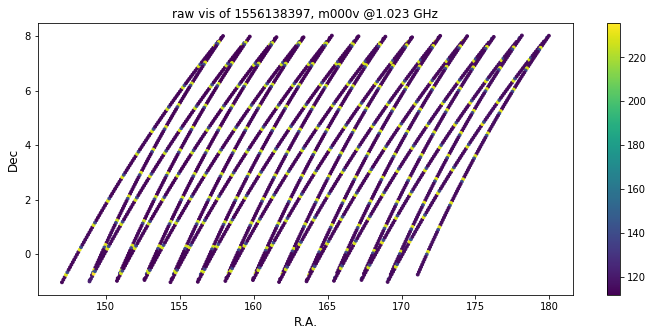

In [18]:
#raw vis map to check diode injection power and period
p_data=vis[dp_ss,ch_plot]
plt.figure(figsize=(12,5))
plt.scatter(ra[dp_ss],dec[dp_ss], c=p_data, vmin=np.min(p_data),vmax=np.max(p_data), s=8)
plt.colorbar()
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'_'+str(recv1)+'_map_scan.pdf')
plt.show()

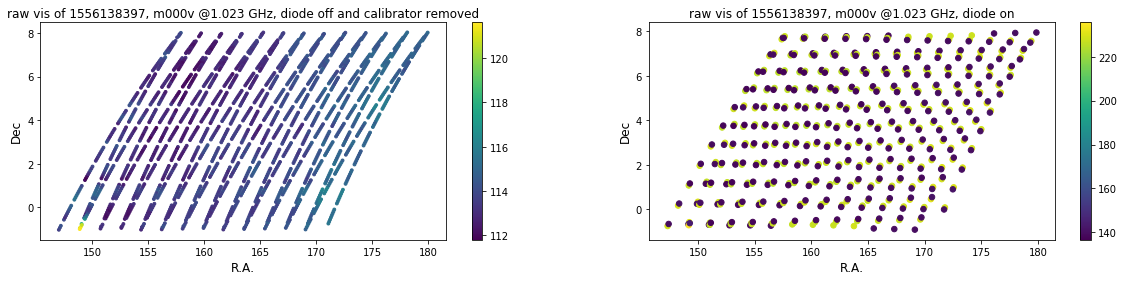

In [19]:
#diode off and diode on parts for above plot
plt.figure(figsize=(20,4))
plt.subplot(121)
p_data=vis[nd_s0,ch_plot]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=np.min(p_data),vmax=np.max(p_data), s=8)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.subplot(122)
p_data=vis[nd_s1,ch_plot]
plt.scatter(ra[nd_s1],dec[nd_s1], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=30)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode on',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.show()

<type 'numpy.ndarray'>


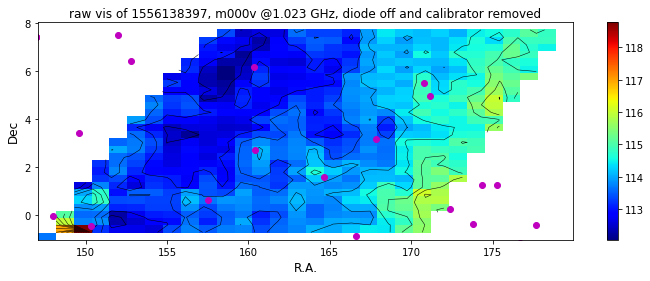

In [20]:
#interpolation map to show the raw vis data vis point sources (magenta dots)
p_data=vis[nd_s0,ch_plot]
plt.figure(figsize=(12,4))
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.show()

In [21]:
from astropy.coordinates import SkyCoord
from astropy import units as u
p = SkyCoord(data.ra*u.deg,  data.dec*u.deg, frame='icrs')
dp_ptr_list=[]

for i in range(len(p_radec)):
    #print i
    p_ra,p_dec=p_radec[i]
    c = SkyCoord(p_ra*u.deg,  p_dec*u.deg, frame='icrs')
    #print c 
    p_ang=(c.separation(p)/u.deg)[:,0]
    #print p_ang
    dp_l=np.where(p_ang<1.)[0]
    #print dp_l
    for j in range(len(dp_l)):
        if dp_l[j]>dp_sb and dp_l[j]<=dp_se:
            dp_ptr_list.append(dp_l[j])

list(set(dp_ptr_list))
dp_ptr_list.sort()
dp_s0_ptr=list(set(dp_ptr_list).intersection(nd_s0))

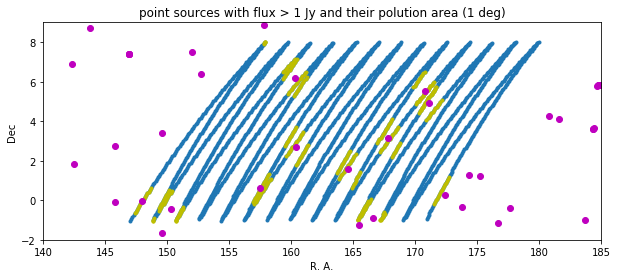

In [22]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra[dp_s],dec[dp_s],'.-')
plt.plot(ra[dp_ptr_list],dec[dp_ptr_list],'y.')
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.xlim(140,185)
plt.ylim(-2,9)
plt.title('point sources with flux > 1 Jy and their polution area (1 deg)')
plt.show()

# RFI flagging

## Basic RFI flagging (all channels)

In [23]:
#set the thresholds for SEEK 
First_Thresholds=[30, 60, 35, 70]


In [24]:
#rfi flagging for raw vis data
vis_clean=kr.vis_flag(vis_backup,flags,nd_label0, dp_w, First_Thresholds)

group shape (no flags):
286 286 572 2220 84 83 167 671
### load flags ###
data.flags ratio:
0.0650236540512
###mask data not track/scan###
---------------------------------------------------
###SEEK flagging###
First_Threshold_0, First_Threshold_1, First_Threshold_00, First_Threshold_11= [30, 60, 35, 70]
#flagging scan and nd_0
Std of the non-masked elements of tod is 27.37
Std/Mean of the non-masked elements of tod is 0.32
#flagging scan and nd_1a
Std of the non-masked elements of tod is 55.53
Std/Mean of the non-masked elements of tod is 0.31
#flagging scan and nd_1b
Std of the non-masked elements of tod is 34.53
Std/Mean of the non-masked elements of tod is 0.31
#flagging track and nd_0
Std of the non-masked elements of tod is 31.89
Std/Mean of the non-masked elements of tod is 0.34
#flagging track and nd_1a
Std of the non-masked elements of tod is 60.04
Std/Mean of the non-masked elements of tod is 0.32
#flagging track and nd_1b
Std of the non-masked elements of tod is 39.01
Std/Me

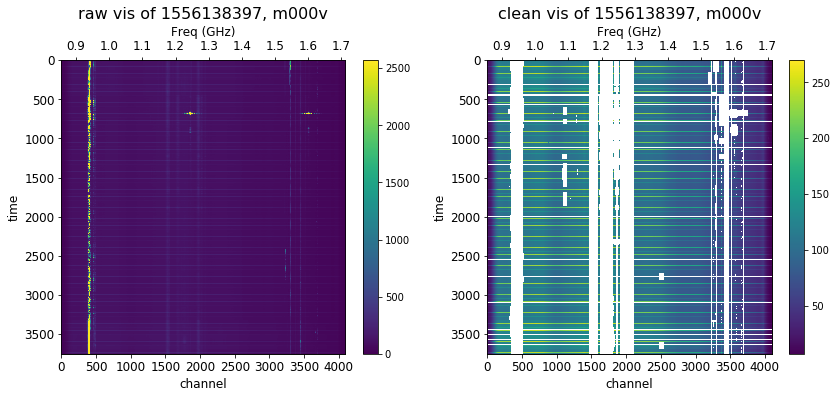

In [25]:
#compare vis before and after rfi flagging

plt.figure(figsize=(14,5.4))
plt.subplot(121)
plt.imshow(vis_backup,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('raw vis of '+str(fname)+', '+str(recv),fontsize=16, y=1.12)
plt.colorbar()
plt.twiny()
plt.xticks(fontsize=12)
plt.imshow(vis_backup,aspect='auto',extent=(data.freqs[0]/1e9,data.freqs[-1]/1e9,len(timestamps),0))
plt.xlabel('Freq (GHz)',fontsize=12)
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('clean vis of '+str(fname)+', '+str(recv),fontsize=16, y=1.12)
plt.colorbar()
plt.twiny()
plt.xticks(fontsize=12)
plt.imshow(vis_clean,aspect='auto',extent=(data.freqs[0]/1e9,data.freqs[-1]/1e9,len(timestamps),0))
plt.xlabel('Freq (GHz)',fontsize=12)
#plt.savefig(str(fname)+'raw_vis.pdf')
plt.show()

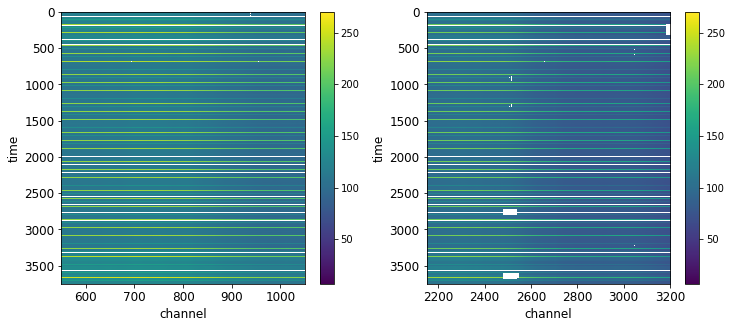

In [26]:
#####to show the part we are intrested (rfi 'free')####
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.xlim(550,1050)
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.xlim(2150,3200)
plt.colorbar()
plt.show()

## additional flagging for single channel (not necessary if no small RFI)

800


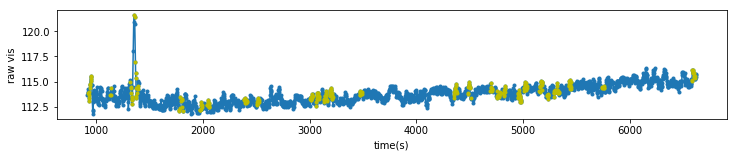

In [27]:
#check the raw vis along time in the single channel
print ch_plot
plt.figure(figsize=(12,2))
plt.plot(timestamps[nd_s0]-timestamps[0],vis_clean[nd_s0,ch_plot],'.-')
plt.plot(timestamps[dp_s0_ptr]-timestamps[0],vis_clean[dp_s0_ptr,ch_plot],'y.')
plt.xlabel('time(s)')
plt.ylabel('raw vis')
plt.show()


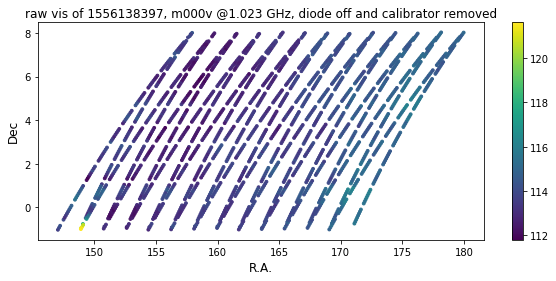

In [28]:
#check the raw vis scan map in the single channel
p_data=vis_clean[nd_s0,ch_plot]
plt.figure(figsize=(10,4))
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
#plt.savefig(str(fname)+'map_clean.pdf')
plt.show()

In [29]:
###aplly the flagging
vis_clean_old=vis_clean.copy() ###backup
vis_clean,nd_s0_clean=kr.vis_flag_1ch(vis_clean,nd_labels,ch_plot)

group shape (with flags):
279 277 556 2208 83 81 164 640
iter=0
iter=1
iter=2


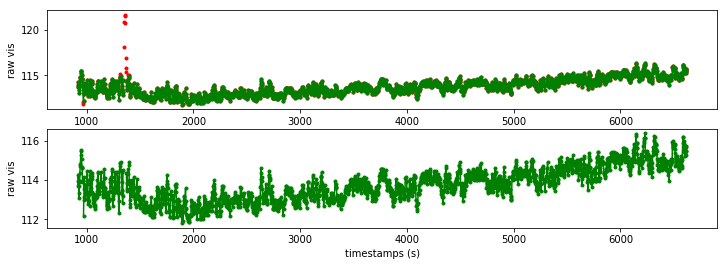

In [30]:
#show the result
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(timestamps[nd_s0]-timestamps[0],vis_clean_old[nd_s0,ch_plot],'r.') #before flagging
plt.plot(timestamps[nd_s0_clean]-timestamps[0],vis_clean_old[nd_s0_clean,ch_plot],'g.-') #after flagging
plt.xlabel('timestamps (s)')
plt.ylabel('raw vis')
plt.subplot(212)
plt.plot(timestamps[nd_s0]-timestamps[0],vis_clean[nd_s0,ch_plot],'g.-') #check vis_clean updated
plt.xlabel('timestamps (s)')
plt.ylabel('raw vis')
plt.show()


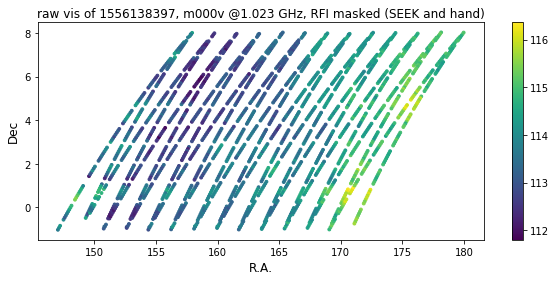

In [31]:
#show the new vis map
plt.figure(figsize=(10,4))
p_data=vis_clean[nd_s0_clean,ch_plot]
plt.scatter(ra[nd_s0_clean],dec[nd_s0_clean], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK and hand)',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
#plt.savefig(str(fname)+'map_clean.pdf')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


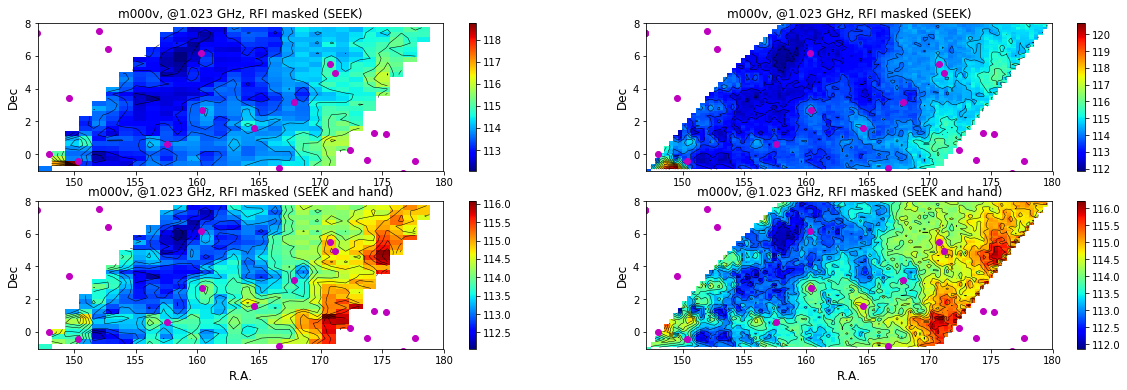

In [32]:
###compare the map before and after single channel flagging##########
plot_gsize=90
plt.figure(figsize=(20,6))
plt.subplot(221)
p_data=vis_clean_old[nd_s0,ch_plot]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK)',fontsize=12)
#plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'map_clean_grid.pdf')
plt.subplot(222)
p_data=vis_clean_old[nd_s0,ch_plot]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data, gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK)',fontsize=12)
#plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'map_clean_grid.pdf')
plt.subplot(223)
p_data=vis_clean[nd_s0_clean,ch_plot]
kv.plot_data(ra[nd_s0_clean],dec[nd_s0_clean], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK and hand)',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'map_clean_grid.pdf')
plt.subplot(224)
p_data=vis_clean[nd_s0_clean,ch_plot]
kv.plot_data(ra[nd_s0_clean],dec[nd_s0_clean], p_data, gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK and hand)',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'rfi_check_map.pdf')
plt.show()

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


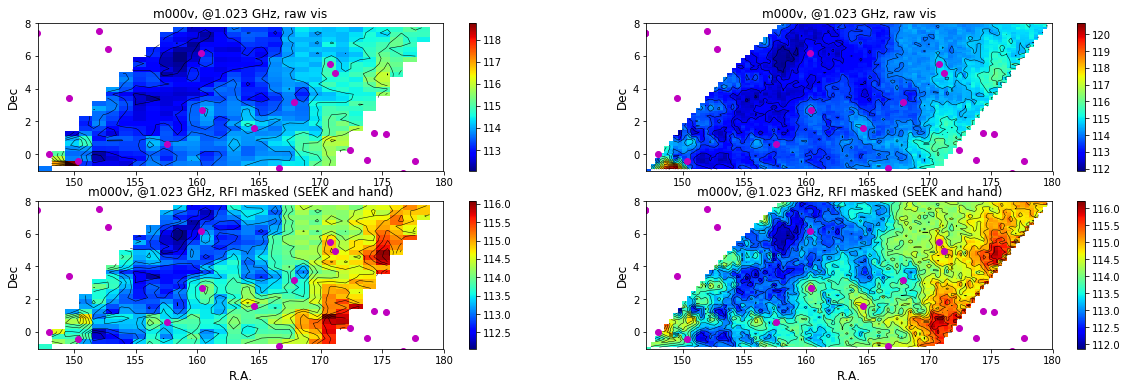

In [33]:
#####compare the raw vis map and after flagging######
plot_gsize=90
plt.figure(figsize=(20,6))
plt.subplot(221)
p_data=vis[nd_s0,ch_plot]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, raw vis',fontsize=12)
#plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'map_clean_grid.pdf')
plt.subplot(222)
p_data=vis[nd_s0,ch_plot]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data, gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, raw vis',fontsize=12)
#plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'map_clean_grid.pdf')
plt.subplot(223)
p_data=vis_clean[nd_s0_clean,ch_plot]
kv.plot_data(ra[nd_s0_clean],dec[nd_s0_clean], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK and hand)',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'map_clean_grid.pdf')
plt.subplot(224)
p_data=vis_clean[nd_s0_clean,ch_plot]
kv.plot_data(ra[nd_s0_clean],dec[nd_s0_clean], p_data, gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title(str(recv)+ ', @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, RFI masked (SEEK and hand)',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'_'+str(recv1)+'_rfi_comp_map.pdf')
plt.show()

# calibrate the diode noise using point source calibrator 

## load the foreground models

In [34]:
#load the scan and track labels 
dp_u=kl.cal_dp_u(dp_tt,dp_ss)

#cal_Tspill is for single channel only! cal_Tspill_func has higher efficiency for multi channel calibration


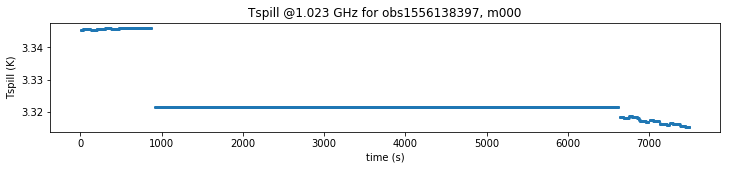

In [35]:
#spill model 
#Tspill=km.cal_Tspill(el,pol,freqs, ch_plot,1) #raw vesrion from katconfig, with an interpolation problem
Tspill=km.cal_Tspill(el,pol,freqs, ch_plot,2) #fixed version

plt.figure(figsize=(12,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tspill[dp_u],'.', ms=3)
plt.title('Tspill @'+str(round(freqs[ch_plot]/1e9,3)) +' GHz for obs'+fname+', '+ant)
plt.xlabel('time (s)')
plt.ylabel('Tspill (K)')
plt.show()

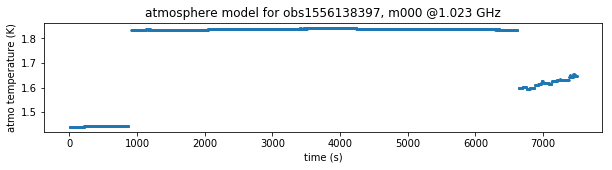

In [36]:
#atmosphere emission model
Tatmo=km.calc_atmosphere_model_1ch(data,ch_plot)

plt.figure(figsize=(10,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tatmo[dp_u],'.', ms=3)
plt.xlabel('time (s)')
plt.ylabel('atmo temperature (K)')
plt.title('atmosphere model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

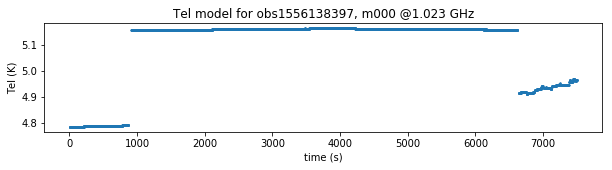

In [37]:
#elevation related emission model
Tel=Tspill+Tatmo 

plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_u]-data.timestamps[0],Tel[dp_u],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

#cal_Tnd is for single channel only! Tnd_spl has higher efficiency for multi channel calibration
l.4028 h
l.4028 v
1.33812408037


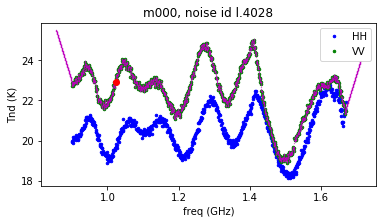

In [38]:
#load the diode injection model and get a reference value
#note: diode version are different dish by dish!
Tnd_std,Tnd_ref,noise,Tnd_spl= km.call_Tnd(data, ant, pol,freqs,ch_plot,1)


In [39]:
#Galactic model
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
gal=km.cal_Gal_model_np(vis, freqs, ra, dec, ch_plot, ch_plot+1, nside)

## load calibrator model: related to the beam model##################


In [40]:
#BM-I: calculated Gaussian
T_ptr0=kb.cal_BMI(freqs,ch_plot,flux_model,ang_deg)


127.858400702
alpha=0.21892182564


In [41]:
#select beam pattern model
beam_select='me'

In [42]:
#BM-II: pattern fitted Gaussian
T_ptr1=kb.cal_BMII(freqs,ch_plot,pol,flux_model,ang_deg,beam_select)


#load_Bdata is for single channel only! load_Bdata_fband has higher efficiency for multi channel calibration
p513_d5_ch4096/p1
alpha=0.21892182564


In [43]:
#BM-III:pattern

#check pointing stable fro track part
if fname in ['1551055211','1551037708']:
    dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c2a,dp_c3a,dp_c4a,dp_c0b,dp_c1b,dp_c2b,dp_c3b,dp_c4b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg)
else:
    dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c0b,dp_c1b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg)

deg filter start: 0.700296718025+/-0.0180042818111
deg filter end: 0.699996844528+/-0.00019454912303

deg filter start: 0.000447263853319+/-0.00333368584507
deg filter end: 0.000255770185331+/-0.000188763307681



In [44]:
#calculate position
T_ptr2,pattern,pix_label=kb.cal_BMIII(fname,data,ch_plot,ant,pol,flux_model,c0,dp_ca,dp_cb,ang_deg,beam_select)
x_pix,y_pix,x_pix_max,y_pix_max=pix_label

#cal_BMIII is for single channel only! cal_BMIII_1ch has higher efficiency for multi channel calibration
(3752,) (3752,)
#load_Bdata is for single channel only! load_Bdata_fband has higher efficiency for multi channel calibration
p513_d5_ch4096/p1
129.062047951
p513_d5_ch4096/p1
5.0
/users/jywang/MeerKAT/model_test/beam_model/eidos_sim/p513_d5_ch4096/p1/primary_beam_me_p513_1024channels_5deg_re_part1.fits
/users/jywang/MeerKAT/model_test/beam_model/eidos_sim/p513_d5_ch4096/p1/primary_beam_me_p513_1024channels_5deg_im_part1.fits
(1024, 2, 2, 513, 513)
513
800
1.00097286506 1.00105297353
1.0 1.0
256.0 256.0
(array([255]), array([256]))
255 256
alpha=0.21892182564


/usr/lib/python2.7/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


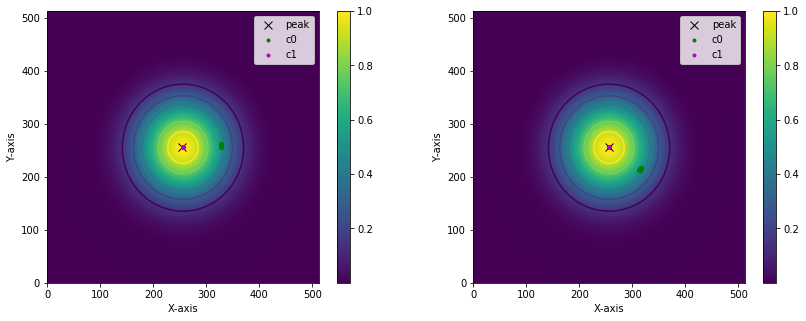

In [45]:
#show pointing position on beam pattern
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.contour(pattern,color='w')
plt.imshow(pattern)
plt.plot(x_pix_max,y_pix_max,'kx',ms=8)
plt.plot(x_pix[dp_c0a],y_pix[dp_c0a],'g.')
plt.plot(x_pix[dp_c1a],y_pix[dp_c1a],'m.')
if fname in ['1551055211','1551037708']:
    plt.plot(x_pix[dp_c2a],y_pix[dp_c2a],'.')
    plt.plot(x_pix[dp_c3a],y_pix[dp_c3a],'.')
    plt.plot(x_pix[dp_c4a],y_pix[dp_c4a],'.')
plt.gca().invert_yaxis()
plt.legend(['peak','c0','c1','c2','c3','c4'])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.subplot(122)
plt.contour(pattern,color='w')
plt.imshow(pattern)
plt.plot(x_pix_max,y_pix_max,'kx',ms=8)
plt.plot(x_pix[dp_c0b],y_pix[dp_c0b],'g.')
plt.plot(x_pix[dp_c1b],y_pix[dp_c1b],'m.')
if fname in ['1551055211','1551037708']:
    plt.plot(x_pix[dp_c2b],y_pix[dp_c2b],'.')
    plt.plot(x_pix[dp_c3b],y_pix[dp_c3b],'.')
    plt.plot(x_pix[dp_c4b],y_pix[dp_c4b],'.')
plt.gca().invert_yaxis()
plt.legend(['peak','c0','c1','c2','c3','c4'])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.show()

## calibrate diode noise

In [46]:
#####choose beam model
T_ptr=T_ptr2 #BM-III 

### track before scan########################


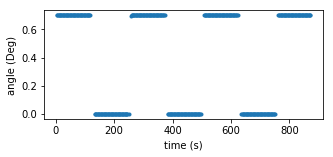

In [47]:
#check angular distance
plt.figure(figsize=(5,2))
plt.plot(timestamps[dp_ca]-timestamps[0],ang_deg[dp_ca],'.')
plt.xlabel('time (s)')
plt.ylabel('angle (Deg)')
plt.show()


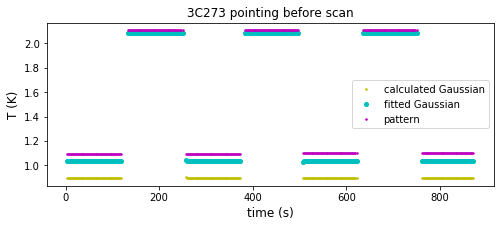

In [48]:
#check Tptr from different model

plt.figure(figsize=(8,3))
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr0[dp_ca],'y.',ms=3)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr1[dp_ca],'c.',ms=8)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr2[dp_ca],'m.',ms=3)

plt.xlabel('time (s)',fontsize=12)
plt.ylabel('T (K)',fontsize=12)
plt.title(target+' pointing before scan')
plt.legend(['calculated Gaussian', 'fitted Gaussian', 'pattern'])
plt.show()

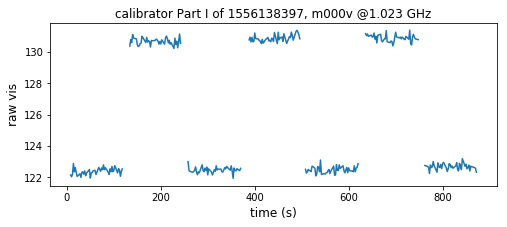

In [49]:
#select raw vis for track befor scan
visa_ptr = vis_clean.copy()
for i in range(len(timestamps)):
    if i not in dp_ca:
        visa_ptr.mask[i,:]=True
#show diode off data
plt.figure(figsize=(8,3))
plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr[nd_0,ch_plot])
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

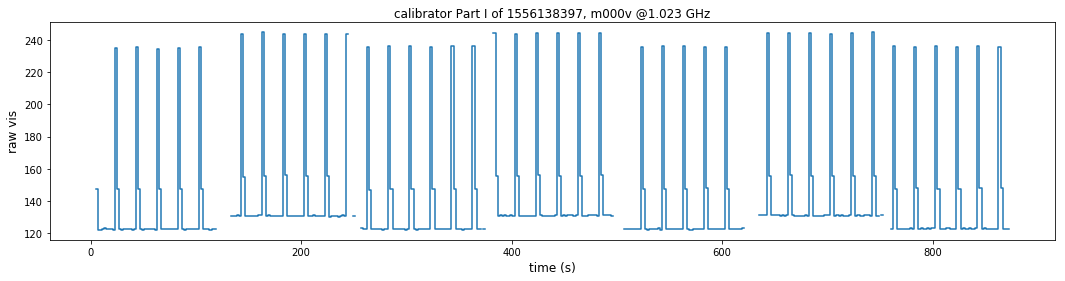

In [50]:
#diode on and diode off 
plt.figure(figsize=(18,4))
plt.step(timestamps-timestamps[0],visa_ptr[:,ch_plot],where='mid')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

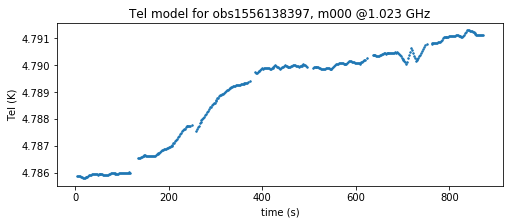

In [51]:
#show Tel for track before scan
plt.figure(figsize=(8,3))
plt.plot(data.timestamps[dp_ca]-data.timestamps[0],Tel[dp_ca],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

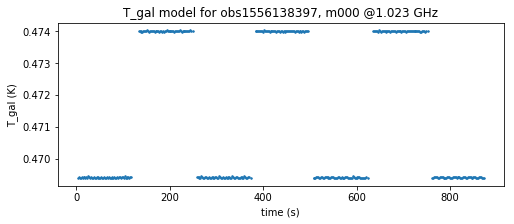

In [52]:
#show Tgal for track efor scan
Tgal=gal[:,ch_plot]
plt.figure(figsize=(8,3))
plt.plot(data.timestamps[dp_ca]-data.timestamps[0],Tgal[dp_ca],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('T_gal (K)')
plt.title('T_gal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()
plt.show()

In [53]:
####set input parameters
ga0,gb0=ks.cal_gain0(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg,T_ptr,vis_clean) #gain level

Tsys0=10.
eta_p0=1.0
func_sm_param0=[Tsys0]
func_gt_param0=[ga0,0,0,0,0]
ratio0=0.5


####fitting
#instru_pa=ks.solve_params0(timestamps, visa_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
#                      func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
instru_pa=ks.solve_params0_test2(timestamps, visa_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                      func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)

####get fitting result
Tnda=instru_pa[0]
eta_pa=instru_pa[1]
sma=instru_pa[2]
gta=instru_pa[3:-1]
ratioa=instru_pa[-1]
print Tnda, eta_pa, ratioa , sma, gta

deg filter start: 0.700296718025+/-0.0180042818111
deg filter end: 0.699996844528+/-0.00019454912303

deg filter start: 0.000447263853319+/-0.00333368584507
deg filter end: 0.000255770185331+/-0.000188763307681

Optimization terminated successfully.
         Current function value: 10718.041388
         Iterations: 7
         Function evaluations: 621
19.0073081818 1.0 0.738368262226 6.09051087473 [  8.08261596e+00   4.48848062e-04  -1.47859639e-03   4.33256541e-03
  -9.13474689e-03]


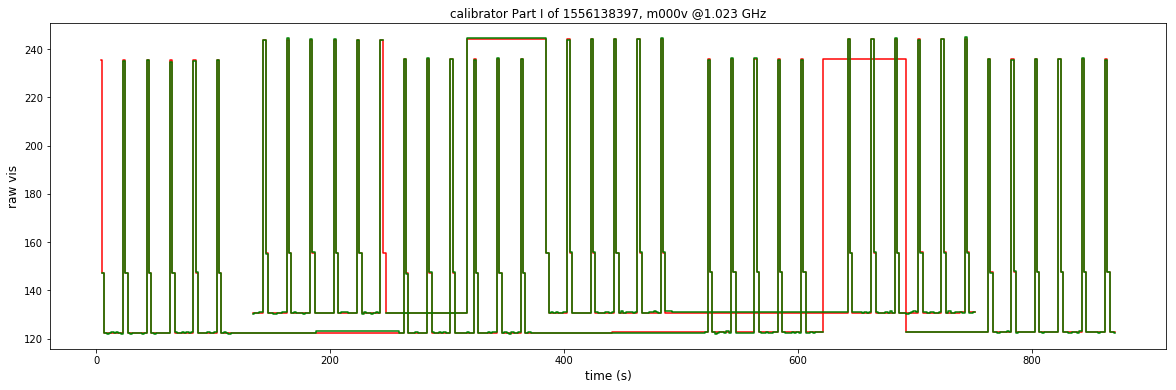

In [54]:
##show model and raw vis
plt.figure(figsize=(20,6))
#m=ks.calc_total_model(timestamps, nd_ratio, ratioa, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1a, nd_1b)
m=ks.calc_total_model_test2(timestamps, nd_ratio, ratioa, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1a, nd_1b)
plt.step(timestamps[dp_c0a]-timestamps[0],m[dp_c0a],'r-',where='mid')
plt.step(timestamps[dp_c1a]-timestamps[0],m[dp_c1a],'r-',where='mid')

plt.step(timestamps[dp_c0a]-timestamps[0],visa_ptr[dp_c0a,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c1a]-timestamps[0],visa_ptr[dp_c1a,ch_plot],'g-',where='mid')
if fname in ['1551055211','1551037708']:
    plt.step(timestamps[dp_c2a]-timestamps[0],m[dp_c2a],'r-',where='mid')
    plt.step(timestamps[dp_c3a]-timestamps[0],m[dp_c3a],'r-',where='mid')
    plt.step(timestamps[dp_c4a]-timestamps[0],m[dp_c4a],'r-',where='mid')
    plt.step(timestamps[dp_c2a]-timestamps[0],visa_ptr[dp_c2a,ch_plot],'g-',where='mid')
    plt.step(timestamps[dp_c3a]-timestamps[0],visa_ptr[dp_c3a,ch_plot],'g-',where='mid')
    plt.step(timestamps[dp_c4a]-timestamps[0],visa_ptr[dp_c4a,ch_plot],'g-',where='mid')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

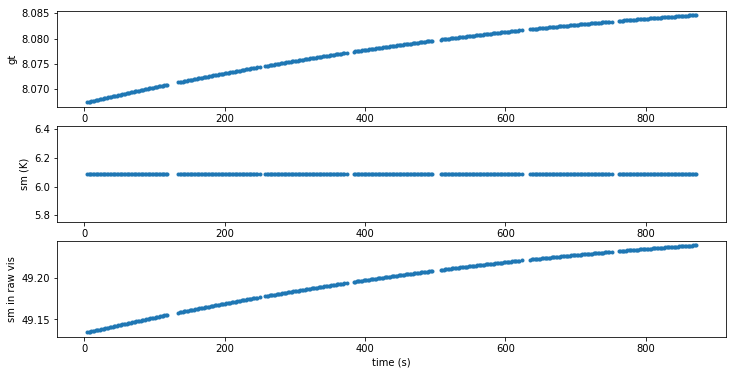

In [55]:
#show curves for fitting parameters
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca],'.')
plt.ylabel('gt')
plt.subplot(312)
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_sm(timestamps,sma)[dp_ca],'.')
plt.ylabel('sm (K)')
plt.subplot(313)
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca]*ks.func_sm(timestamps,sma)[dp_ca],'.')
plt.xlabel('time (s)')
plt.ylabel('sm in raw vis')
plt.show()

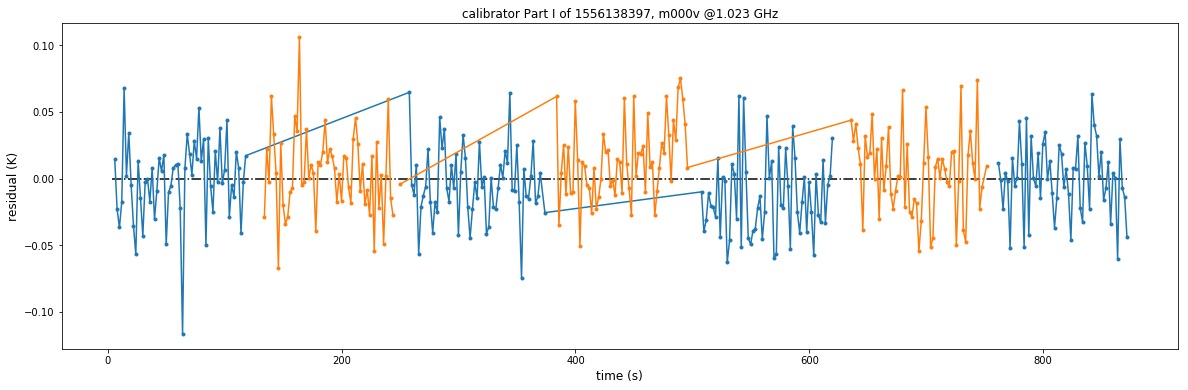

In [56]:
#show residuals
plt.figure(figsize=(20,6))
g=ks.func_gt(timestamps,gta)
#m=ks.calc_total_model(timestamps, nd_ratio, ratioa, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1a, nd_1b)
m=ks.calc_total_model_test2(timestamps, nd_ratio, ratioa, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1a, nd_1b)
plt.plot([timestamps[dp_c0a][0]-timestamps[0],timestamps[dp_c0a][-1]-timestamps[0]],[0,0],'k-.')
plt.plot(timestamps[dp_c0a]-timestamps[0],(visa_ptr[dp_c0a,ch_plot]-m[dp_c0a])/g[dp_c0a],'.-')
plt.plot(timestamps[dp_c1a]-timestamps[0],(visa_ptr[dp_c1a,ch_plot]-m[dp_c1a])/g[dp_c1a],'.-')
if fname in ['1551055211','1551037708']:
    plt.plot(timestamps[dp_c2a]-timestamps[0],(visa_ptr[dp_c2a,ch_plot]-m[dp_c2a])/g[dp_c2a],'.-')
    plt.plot(timestamps[dp_c3a]-timestamps[0],(visa_ptr[dp_c3a,ch_plot]-m[dp_c3a])/g[dp_c3a],'.-')
    plt.plot(timestamps[dp_c4a]-timestamps[0],(visa_ptr[dp_c4a,ch_plot]-m[dp_c4a])/g[dp_c4a],'.-')
    plt.plot([timestamps[dp_c0a][0]-timestamps[0],timestamps[dp_c4a][-1]-timestamps[0]],[0,0],'k-.')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('residual (K)',fontsize=12)
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
#plt.savefig('caliA_ch'+str(ch_plot)+'.png')
plt.show()


### track after scan########################


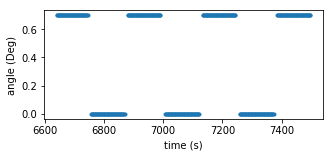

In [57]:
#check angular distance
plt.figure(figsize=(5,2))
plt.plot(timestamps[dp_cb]-timestamps[0],ang_deg[dp_cb],'.')
plt.xlabel('time (s)')
plt.ylabel('angle (Deg)')
plt.show()


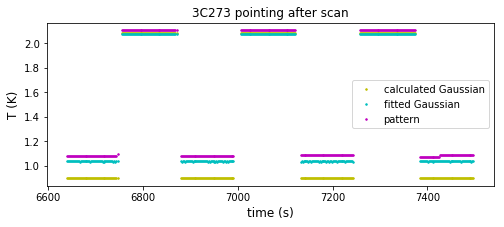

In [58]:
#check Tptr from different model

plt.figure(figsize=(8,3))
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr0[dp_cb],'y.',ms=3)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr1[dp_cb],'c.',ms=3)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr2[dp_cb],'m.',ms=3)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('T (K)',fontsize=12)
plt.title('3C273 pointing after scan')
plt.legend(['calculated Gaussian', 'fitted Gaussian', 'pattern'])
plt.show()

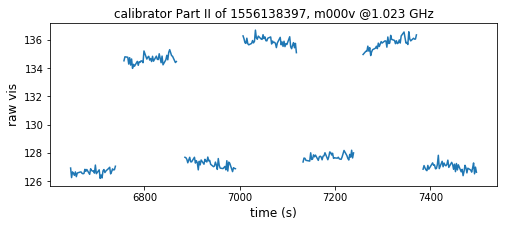

In [59]:
#select raw vis for track befor scan
visb_ptr = vis_clean.copy()
for i in range(len(timestamps)):
    if i not in dp_cb:
        visb_ptr.mask[i,:]=True

#show diode off data
plt.figure(figsize=(8,3))
plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr[nd_0,ch_plot])
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

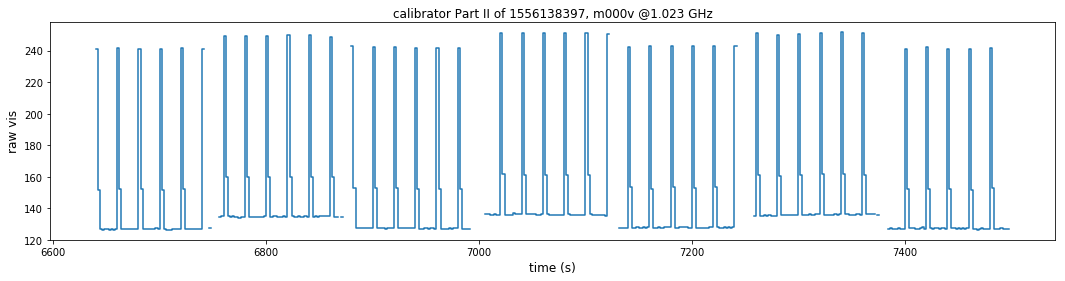

In [60]:
#diode on and diode off 
plt.figure(figsize=(18,4))
plt.step(timestamps-timestamps[0],visb_ptr[:,ch_plot],where='mid')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

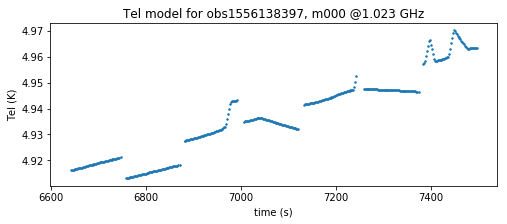

In [61]:
#show Tel for track after scan
plt.figure(figsize=(8,3))
plt.plot(data.timestamps[dp_cb]-data.timestamps[0],Tel[dp_cb],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

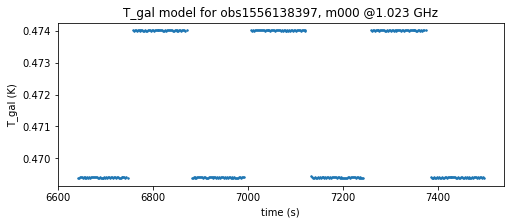

In [62]:
#show Tgal for track after scan
plt.figure(figsize=(8,3))
plt.plot(data.timestamps[dp_cb]-data.timestamps[0],Tgal[dp_cb],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('T_gal (K)')
plt.title('T_gal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()


In [63]:
####set input parameters
Tsys0=10.
eta_p0=1.0
func_sm_param0=[Tsys0]
func_gt_param0=[gb0,0,0,0,0]
ratio0=0.5


####fitting######
#instru_pb=ks.solve_params0(timestamps, visb_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
#                      func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
instru_pb=ks.solve_params0_test2(timestamps, visb_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                      func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
######get fitting result#####
Tndb=instru_pb[0]
eta_pb=instru_pb[1]
smb=instru_pb[2]
gtb=instru_pb[3:-1]
ratiob=instru_pb[-1]
print Tndb, eta_pb, ratiob , smb, gtb

Optimization terminated successfully.
         Current function value: 27898.748577
         Iterations: 16
         Function evaluations: 1458
19.8891675967 1.0 0.738297217798 7.04211688693 [ 7.40469363  0.13887138  0.32361041  0.39401449 -0.46532312]


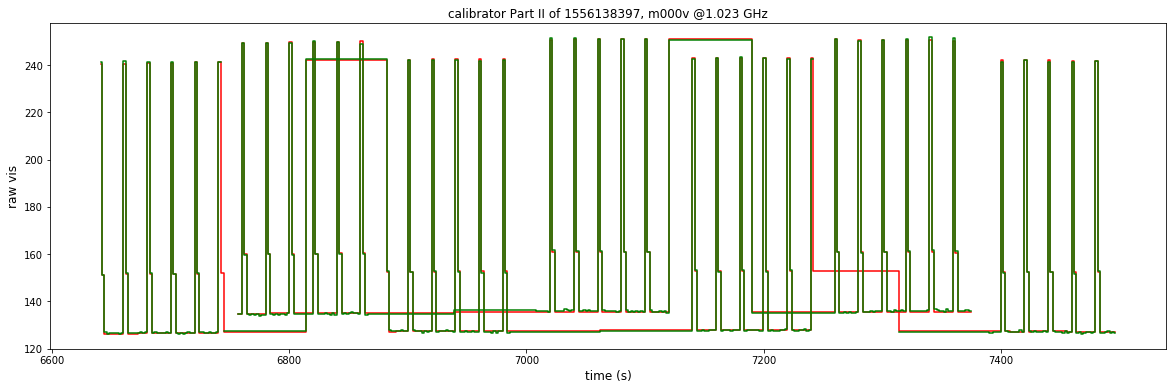

In [64]:
##show model and raw vis
plt.figure(figsize=(20,6))
#m=ks.calc_total_model(timestamps, nd_ratio, ratiob, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_t0, nd_t1a, nd_t1b)
m=ks.calc_total_model_test2(timestamps, nd_ratio, ratiob, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_t0, nd_t1a, nd_t1b)
plt.step(timestamps[dp_c0b]-timestamps[0],m[dp_c0b],'r-',where='mid')
plt.step(timestamps[dp_c1b]-timestamps[0],m[dp_c1b],'r-',where='mid')
plt.step(timestamps[dp_c0b]-timestamps[0],visb_ptr[dp_c0b,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c1b]-timestamps[0],visb_ptr[dp_c1b,ch_plot],'g-',where='mid')
if fname in ['1551055211','1551037708']:
    plt.step(timestamps[dp_c2b]-timestamps[0],m[dp_c2b],'r-',where='mid')
    plt.step(timestamps[dp_c3b]-timestamps[0],m[dp_c3b],'r-',where='mid')
    plt.step(timestamps[dp_c4b]-timestamps[0],m[dp_c4b],'r-',where='mid')
    plt.step(timestamps[dp_c2b]-timestamps[0],visb_ptr[dp_c2b,ch_plot],'g-',where='mid')
    plt.step(timestamps[dp_c3b]-timestamps[0],visb_ptr[dp_c3b,ch_plot],'g-',where='mid')
    plt.step(timestamps[dp_c4b]-timestamps[0],visb_ptr[dp_c4b,ch_plot],'g-',where='mid')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

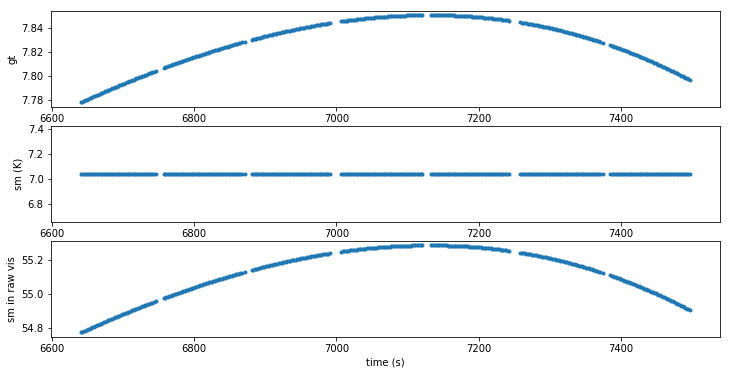

In [65]:
#show curves for fitting parametrs
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb],'.')
plt.ylabel('gt')
plt.subplot(312)
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_sm(timestamps,smb)[dp_cb],'.')
plt.ylabel('sm (K)')
plt.subplot(313)
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb]*ks.func_sm(timestamps,smb)[dp_cb],'.')
plt.xlabel('time (s)')
plt.ylabel('sm in raw vis')
plt.show()

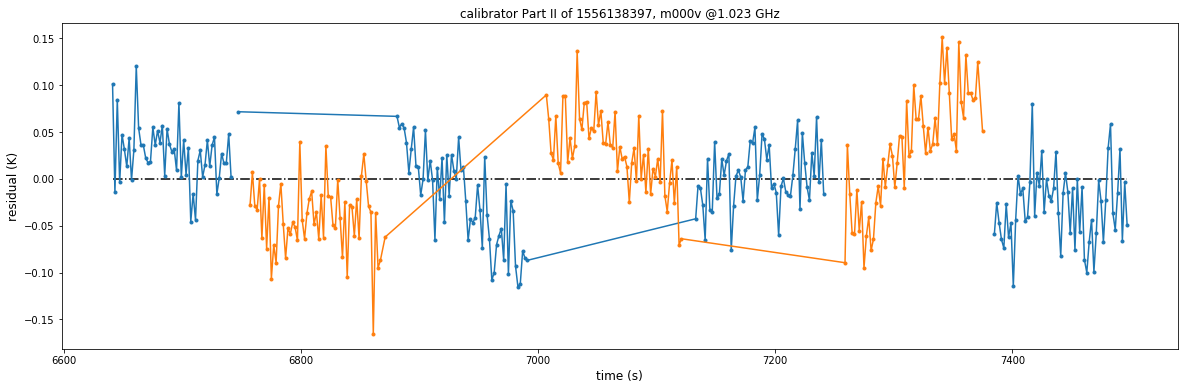

In [66]:
#show residuals
plt.figure(figsize=(20,6))
g=ks.func_gt(timestamps,gtb)
#m=ks.calc_total_model(timestamps, nd_ratio, ratiob, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_t0, nd_t1a, nd_t1b)
m=ks.calc_total_model_test2(timestamps, nd_ratio, ratiob, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_t0, nd_t1a, nd_t1b)
plt.plot([timestamps[dp_c0b][0]-timestamps[0],timestamps[dp_c0b][-1]-timestamps[0]],[0,0],'k-.')
plt.plot(timestamps[dp_c0b]-timestamps[0],(visb_ptr[dp_c0b,ch_plot]-m[dp_c0b])/g[dp_c0b],'.-')
plt.plot(timestamps[dp_c1b]-timestamps[0],(visb_ptr[dp_c1b,ch_plot]-m[dp_c1b])/g[dp_c1b],'.-')
if fname in ['1551055211','1551037708']:
    plt.plot(timestamps[dp_c2b]-timestamps[0],(visb_ptr[dp_c2b,ch_plot]-m[dp_c2b])/g[dp_c2b],'.-')
    plt.plot(timestamps[dp_c3b]-timestamps[0],(visb_ptr[dp_c3b,ch_plot]-m[dp_c3b])/g[dp_c3b],'.-')
    plt.plot(timestamps[dp_c4b]-timestamps[0],(visb_ptr[dp_c4b,ch_plot]-m[dp_c4b])/g[dp_c4b],'.-')
    plt.plot([timestamps[dp_c0b][0]-timestamps[0],timestamps[dp_c4b][-1]-timestamps[0]],[0,0],'k-.')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('residual (K)',fontsize=12)
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
#plt.savefig('caliB_ch'+str(ch_plot)+'.png')
plt.show()

#resi_b=(visb_ptr[dp_c3b,ch_plot]-m[dp_c3b])/g[dp_c3b]
#print resi_b.mean(),resi_b.std()

In [67]:
#check results
print Tnd_ref
print Tnda,Tndb
print eta_pa,eta_pb
print sma,smb


22.9139464379
19.0073081818 19.8891675967
1.0 1.0
6.09051087473 7.04211688693


# Test different calibration methods

## Method A: 
## current calibration, input parameters is Tnd from track part

In [68]:
###set input params
if fname in ['1551037708']:
    Tnd=Tndb
else:
    Tnd=(Tnda+Tndb)/2.

g0=(ga0+gb0)/2.
Tptr=0 #no point source
Tsys0=10.
eta_p0=1.0
func_sm_param0=[Tsys0,0,0,0]
func_gt_param0=[g0,0,0,0,0]#must be [-6:-1] from func_obj_sm
ratio0=0.5

print Tnd,Tnda,Tndb


19.4482378892 19.0073081818 19.8891675967


In [69]:
###raw vis preparsion
vis_clean_tt=vis_clean.copy()
vis_clean_tt.mask[:dp_sb,:]=True
vis_clean_tt.mask[dp_se+1:,:]=True
        

##fitting
instru_p=ks.solve_params_sm(timestamps, vis_clean_tt, ch_plot, nd_ratio, ratio0, Tptr, eta_p0, Tnd, Tel, Tgal,
                      func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)

###output
eta_p=instru_p[0]
sm=instru_p[1:-6]
gt=instru_p[-6:-1] #must be [-5:-1] from func_obj_sm
ratio=instru_p[-1]
print eta_p, ratio, sm, gt

Optimization terminated successfully.
         Current function value: 932108.482180
         Iterations: 11
         Function evaluations: 1213
1.0 0.738220332547 [ 6.21789739  0.06168435  0.05975699 -0.03379515] [ 7.9461317  -0.01496921  0.08783291 -0.02674606  0.02832193]


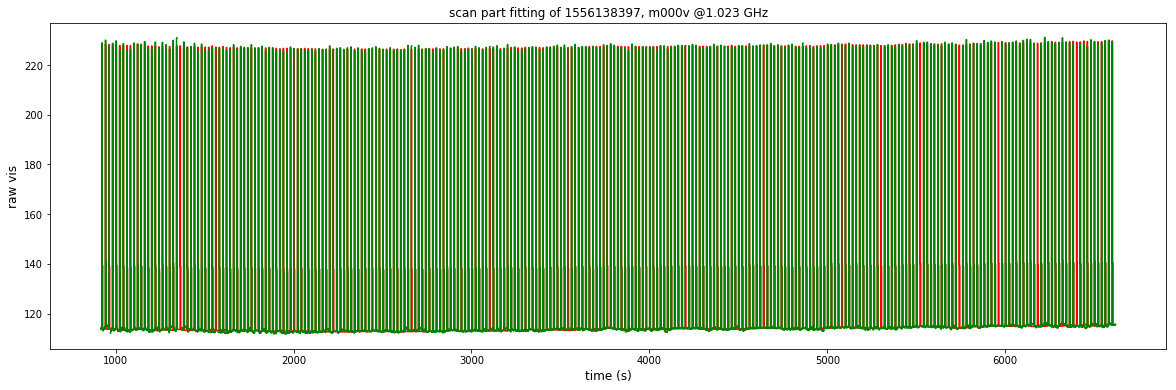

In [70]:
#fitted model and raw vis
# calc_total_model_sm for scan, calc_total_model for calibrator
m=ks.calc_total_model_sm(timestamps, nd_ratio, ratio, Tptr, eta_p, Tnd, Tel, Tgal,  gt, sm, nd_0, nd_1a, nd_1b)

plt.figure(figsize=(20,6))
plt.step(timestamps[dp_sb:dp_se+1]-timestamps[0],m[dp_sb:dp_se+1],'r-',where='mid')
plt.step(timestamps[dp_sb:dp_se+1]-timestamps[0],vis_clean[dp_sb:dp_se+1,ch_plot],'g-',where='mid')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
#plt.xlim(1100,1400)
#plt.savefig('cali_scan.pdf')
plt.show()

-0.00158943453519 0.0612725824396


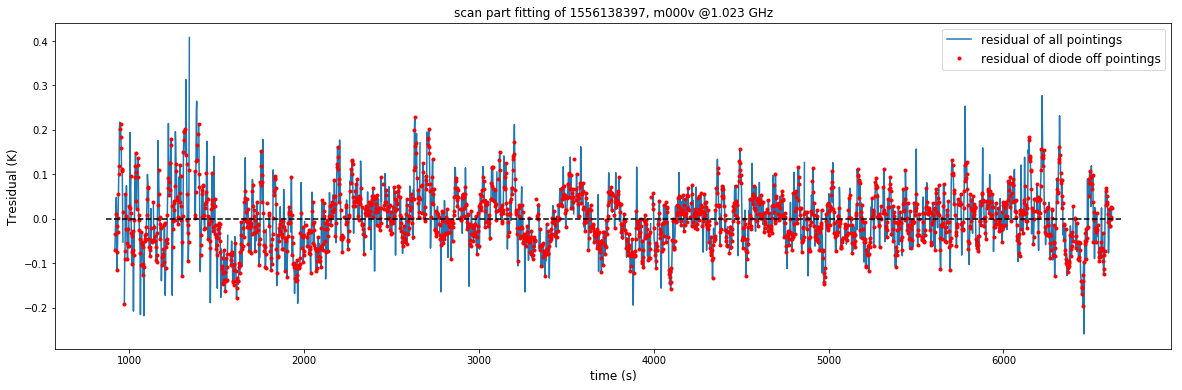

In [71]:
#residual curve
residual=(vis_clean[:,ch_plot]-m)/ks.func_gt(timestamps,gt)
print np.mean(residual[nd_s0]),np.std(residual[nd_s0])

plt.figure(figsize=(20,6))
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0], residual[dp_sb:dp_se+1])
plt.plot(timestamps[nd_s0]-timestamps[0], residual[nd_s0],'r.')
plt.plot([timestamps[dp_sb]-timestamps[0]-50,timestamps[dp_se+1]-timestamps[0]+50],[0,0],'k--')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('Tresidual (K)',fontsize=12)
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
#plt.xlim(1100,1400)
plt.legend(['residual of all pointings', 'residual of diode off pointings'],fontsize=12)
#plt.savefig('cali_scan.pdf')
plt.show()

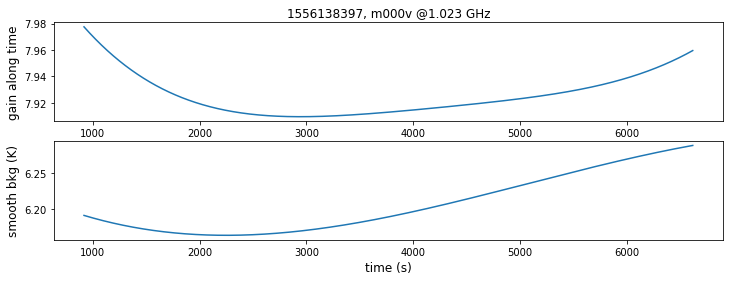

In [72]:
#curves for fitted params
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_gt(timestamps,gt)[dp_sb:dp_se+1])
#plt.xlabel('time (s)',fontsize=12)
plt.ylabel('gain along time',fontsize=12)
plt.title(str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.subplot(212)
#plt.plot(timestamps[nt_scan_b:nt_scan_e+1]-timestamps[0],func_sm_break_long(timestamps,sm,nt_az_edge)[nt_scan_b:nt_scan_e+1])
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_sm(timestamps,sm)[dp_sb:dp_se+1])
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('smooth bkg (K)',fontsize=12)
plt.show()

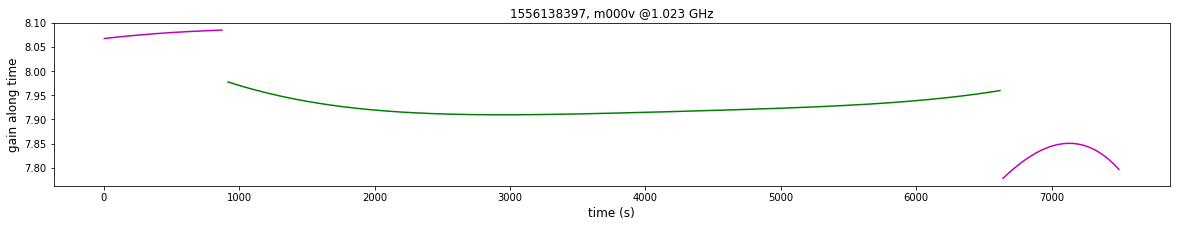

In [73]:
plt.figure(figsize=(20,3))
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca],'m-')
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_gt(timestamps,gt)[dp_sb:dp_se+1],'g')
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb],'m')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('gain along time',fontsize=12)
plt.title(str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

<type 'numpy.ndarray'>


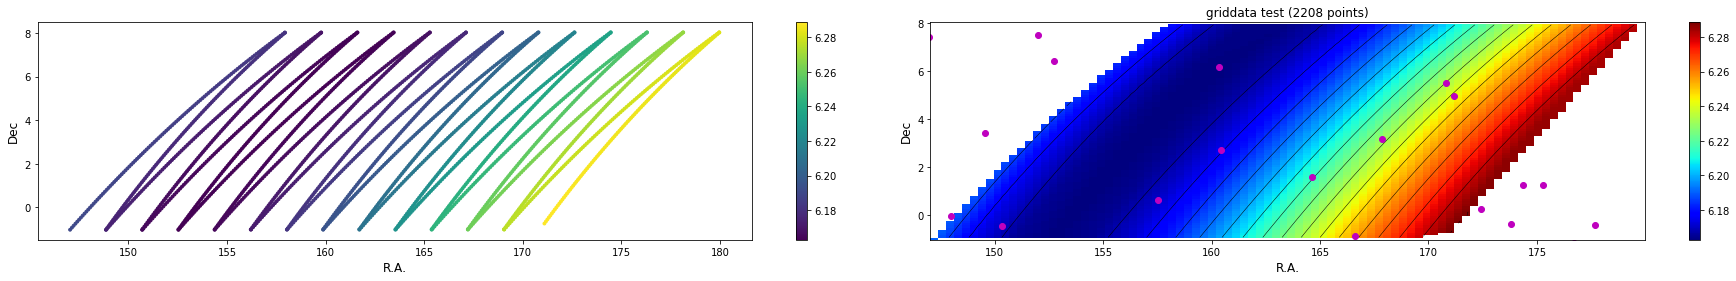

In [74]:
###check the smooth on 2D map

plt.figure(figsize=(32,4))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
p_data=ks.func_sm(timestamps,sm)[dp_sb:dp_se+1]
plt.scatter(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.subplot(122)
p_data=ks.func_sm(timestamps,sm)[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.show()

In [75]:
gt1=gt #save the local result for compare to other methods

## Method B: 
## the first method BOSS want to try, fix the gain in the middle as (gain_before+gain_after)/2.  

In [76]:
print ga0,gb0
print gta,gtb

8.18184614637 7.55098353831
[  8.08261596e+00   4.48848062e-04  -1.47859639e-03   4.33256541e-03
  -9.13474689e-03] [ 7.40469363  0.13887138  0.32361041  0.39401449 -0.46532312]


In [77]:
gb=ks.func_gt(timestamps,gta)[dp_ca][-1]
ge=ks.func_gt(timestamps,gtb)[dp_cb][0]
print gb,ge

'''
gb=np.mean(ks.func_gt(timestamps,gta)[dp_ca])
ge=np.mean(ks.func_gt(timestamps,gtb)[dp_cb])
print gb,ge
'''

8.08467982811 7.77796531101


'\ngb=np.mean(ks.func_gt(timestamps,gta)[dp_ca])\nge=np.mean(ks.func_gt(timestamps,gtb)[dp_cb])\nprint gb,ge\n'

In [78]:
dp_m=int((dp_ca[-1]+dp_cb[0])/2.)
print dp_m

1879


In [79]:
###set input params
#Tnd_ref=(Tnda+Tndb)/2.
g0=(gb+ge)/2.
Tptr=0 #no point source
Tsys0=10.
eta_p0=1.0
func_sm_param0=[Tsys0,0,0,0]
func_gt_param0=[g0,0,0,0,0]#must be [-6:-1] from func_obj_sm
ratio0=0.5



In [80]:
print len(dp_ptr_list)

409


In [81]:
###raw vis preparsion
vis_clean_tt=vis_clean.copy()
vis_clean_tt.mask[:dp_sb,:]=True
vis_clean_tt.mask[dp_se+1:,:]=True
vis_clean_tt.mask[dp_ptr_list,:]=True ###test ptr affect

##fitting
#instru_p=ks.solve_params_sm(timestamps, vis_clean_tt, ch_plot, nd_ratio, ratio0, Tptr, eta_p0, Tnd, Tel, Tgal,
#                      func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
instru_p=ks.solve_params_sm_test2(timestamps, vis_clean_tt, ch_plot, nd_ratio, ratio0, Tptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                      func_gt_param0,  gb, ge, dp_sb,dp_se, dp_m, func_sm_param0, nd_0, nd_1a, nd_1b)

###output
Tnd_cal=instru_p[0]
eta_p=instru_p[1]
sm=instru_p[2:-6]
gt=instru_p[-6:-1] #must be [-5:-1] from func_obj_sm
ratio=instru_p[-1]
print eta_p, ratio


Optimization terminated successfully.
         Current function value: 381962.568791
         Iterations: 7
         Function evaluations: 794
1.0 0.738334605258


In [82]:
print Tnd_ref
print Tnda,Tndb, (Tnda+Tndb)/2.
print Tnd_cal

22.9139464379
19.0073081818 19.8891675967 19.4482378892
19.4395865892


In [83]:
print sma,smb
print sm


6.09051087473 7.04211688693
[ 6.22751101  0.04301738  0.17460883 -0.07813312]


In [84]:
print gb,ge
print ks.func_gt(timestamps,gt)[dp_sb], ks.func_gt(timestamps,gt)[dp_se]

8.08467982811 7.77796531101
7.93132256956 7.93132256956


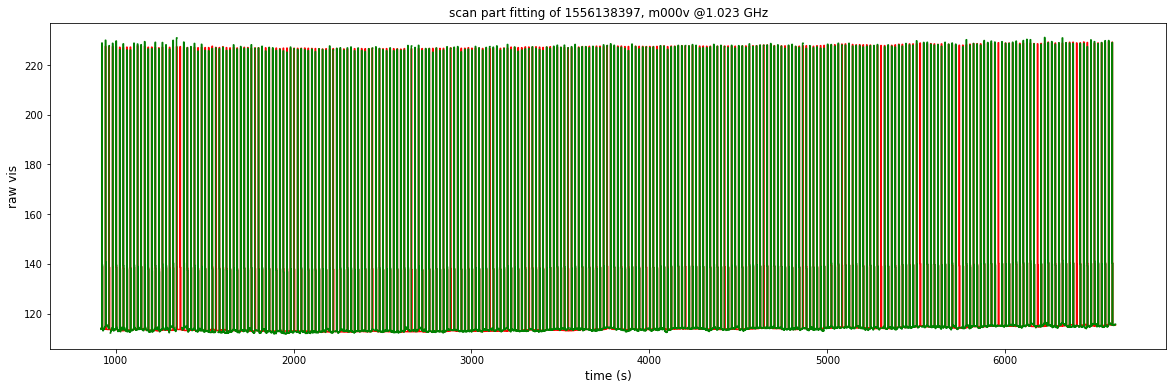

In [85]:
#fitted model and raw vis
# calc_total_model_sm for scan, calc_total_model for calibrator
#m=ks.calc_total_model_sm(timestamps, nd_ratio, ratio, Tptr, eta_p, Tnd, Tel, Tgal,  gt, sm, nd_0, nd_1a, nd_1b)
m=ks.calc_total_model_sm_test2(timestamps, nd_ratio, ratio, Tptr, eta_p, Tnd_cal, Tel, Tgal,  gt, sm, nd_0, nd_1a, nd_1b)
plt.figure(figsize=(20,6))
plt.step(timestamps[dp_sb:dp_se+1]-timestamps[0],m[dp_sb:dp_se+1],'r-',where='mid')
plt.step(timestamps[dp_sb:dp_se+1]-timestamps[0],vis_clean[dp_sb:dp_se+1,ch_plot],'g-',where='mid')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('raw vis',fontsize=12)
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
#plt.xlim(1100,1400)
#plt.savefig('cali_scan.pdf')
plt.show()

0.00347994431623 0.0615828279419


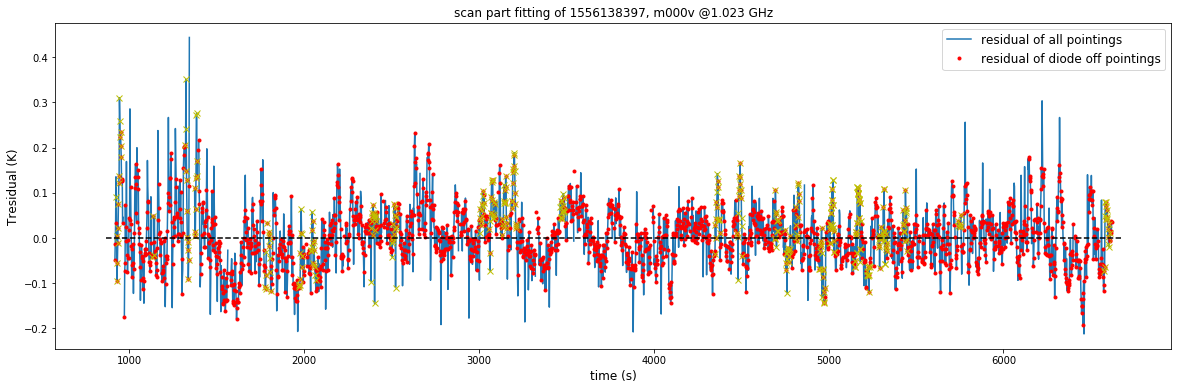

In [86]:
#residual curve
residual=(vis_clean[:,ch_plot]-m)/ks.func_gt(timestamps,gt)
print np.mean(residual[nd_s0]),np.std(residual[nd_s0])

plt.figure(figsize=(20,6))
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0], residual[dp_sb:dp_se+1])
plt.plot(timestamps[nd_s0]-timestamps[0], residual[nd_s0],'r.')
plt.plot(timestamps[dp_ptr_list]-timestamps[0], residual[dp_ptr_list],'yx')
plt.plot([timestamps[dp_sb]-timestamps[0]-50,timestamps[dp_se+1]-timestamps[0]+50],[0,0],'k--')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('Tresidual (K)',fontsize=12)
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
#plt.xlim(1100,1600)
plt.legend(['residual of all pointings', 'residual of diode off pointings'],fontsize=12)
#plt.savefig('cali_scan.pdf')
plt.show()

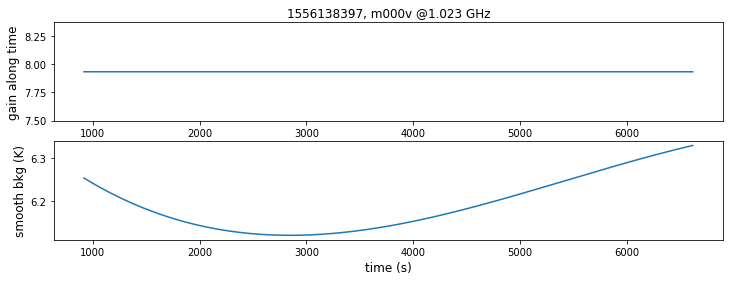

In [87]:
#curves for fitted params
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_gt(timestamps,gt)[dp_sb:dp_se+1])
#plt.xlabel('time (s)',fontsize=12)
plt.ylabel('gain along time',fontsize=12)
plt.title(str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.subplot(212)
#plt.plot(timestamps[nt_scan_b:nt_scan_e+1]-timestamps[0],func_sm_break_long(timestamps,sm,nt_az_edge)[nt_scan_b:nt_scan_e+1])
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_sm(timestamps,sm)[dp_sb:dp_se+1])
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('smooth bkg (K)',fontsize=12)
plt.show()

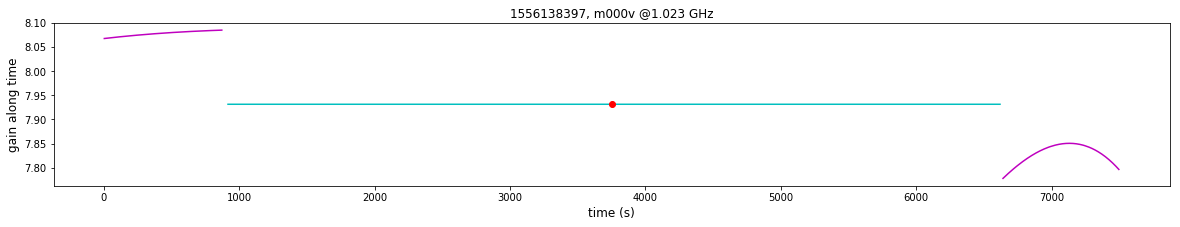

In [88]:
plt.figure(figsize=(20,3))
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca],'m-')
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_gt(timestamps,gt)[dp_sb:dp_se+1],'c')
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb],'m')
plt.plot(timestamps[dp_m]-timestamps[0],(gb+ge)/2.,'ro')
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('gain along time',fontsize=12)
plt.title(str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.show()

<type 'numpy.ndarray'>


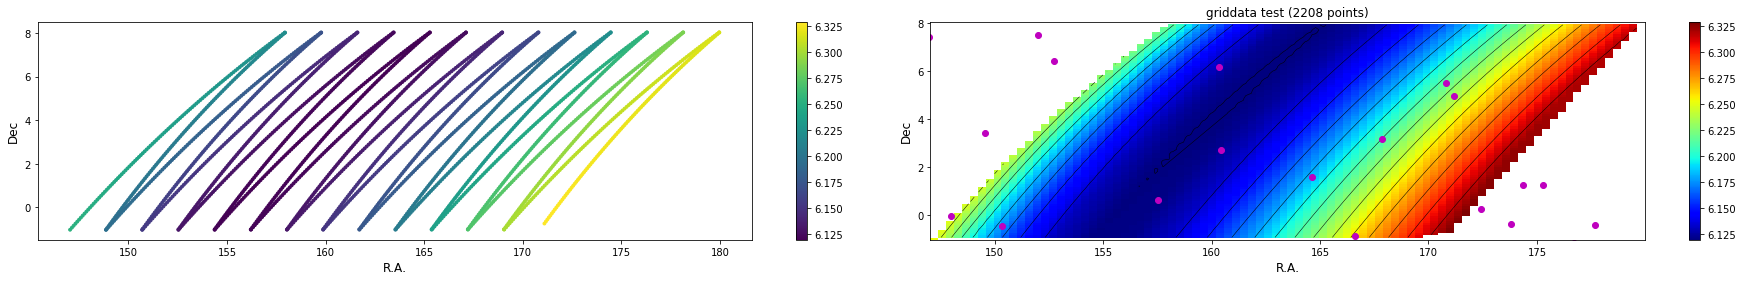

In [89]:
###check the smooth on 2D map

plt.figure(figsize=(32,4))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
p_data=ks.func_sm(timestamps,sm)[dp_sb:dp_se+1]
plt.scatter(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.subplot(122)
p_data=ks.func_sm(timestamps,sm)[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


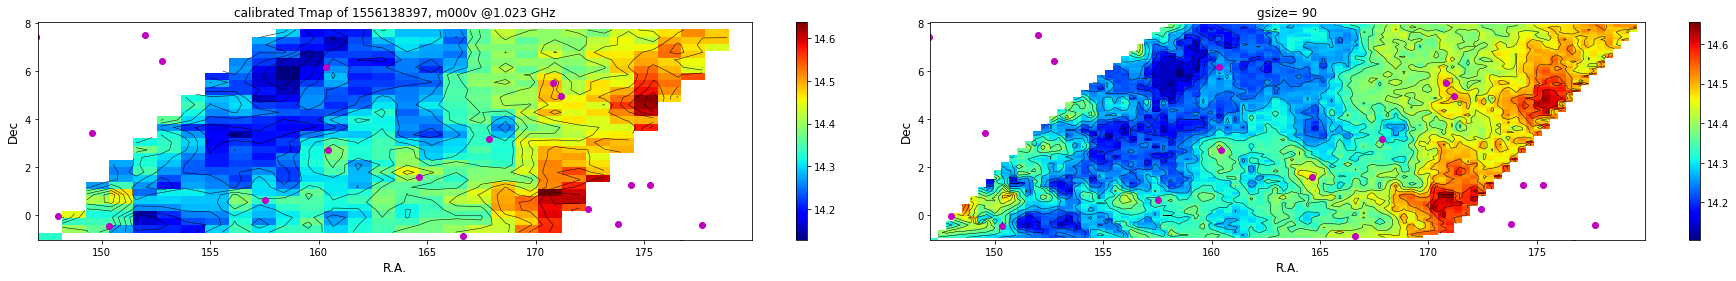

In [90]:
##calibrated map in two resolution
T=vis_clean[:,ch_plot]/ks.func_gt(timestamps,gt)
p_data=T[nd_s0]
plt.figure(figsize=(32,4))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.subplot(122)
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('gsize= '+str(plot_gsize),fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'_'+str(recv)+'_map_calibrated.pdf',bbox_inches='tight')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<type 'numpy.ndarray'>


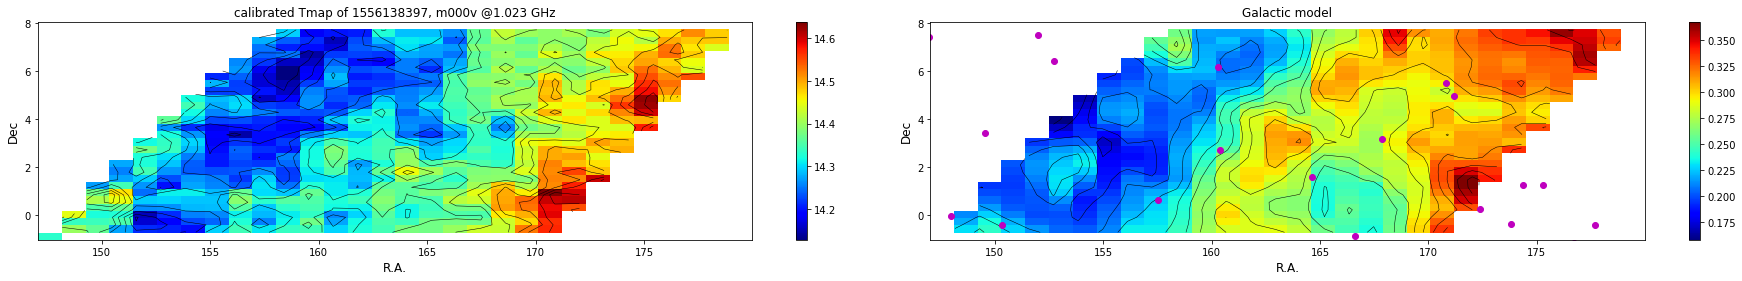

In [91]:
#calibrated map vis Galactic map
plt.figure(figsize=(32,4))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
p_data=T[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
#plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.subplot(122)
p_data=gal[dp_sb:dp_se+1,ch_plot]
kv.plot_data(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('Galactic model', fontsize=12)
plt.show()


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


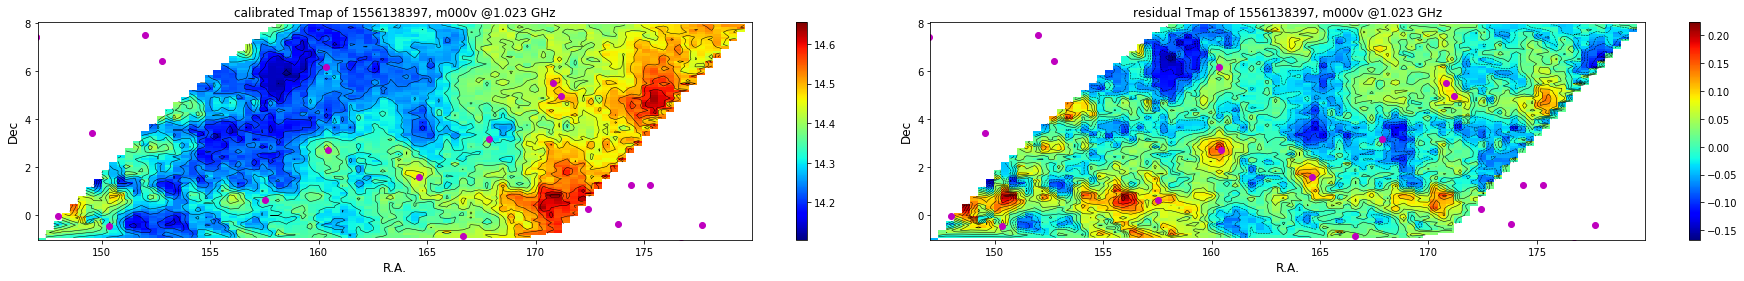

In [92]:
#residual map in different resolution
plt.figure(figsize=(32,4))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
p_data=T[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.subplot(122)
p_data=residual[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('residual Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.show()

In [93]:
gt2=gt #save the local result for compare to other methods

## Method C:
## the second method BOSS want to try,  gain=(raw_vis_on-raw_vis_off)/Tnd 

In [94]:
nd_on1=[]
nd_off1=[]
nd_on2=[]
nd_off2=[]
for i in nd_s1a:
    if (i-1 in nd_s0) is True and (i+1 in nd_s1b) is True and (i+2 in nd_s0) is True:
        
        nd_off1.append(i-1)
        nd_on1.append(i)
        nd_on2.append(i+1)
        nd_off2.append(i+2)
        
print len(nd_on1),len(nd_off1),len(nd_on2),len(nd_off2)
assert (len(nd_on1)==len(nd_off1)) 
assert (len(nd_on1)==len(nd_on2))
assert (len(nd_on2)==len(nd_off2))     



262 262 262 262


In [95]:
Tm=(Tnda+Tndb)/2.
vis_gap=vis_clean[nd_on1,ch_plot]+vis_clean[nd_on2,ch_plot]-vis_clean[nd_off1,ch_plot]-vis_clean[nd_off2,ch_plot]
g_eq=vis_gap/0.9/Tm
g_eq1=vis_gap/0.9/Tnda
g_eq2=vis_gap/0.9/Tndb
g_eq3=vis_gap/0.9/Tnd_ref

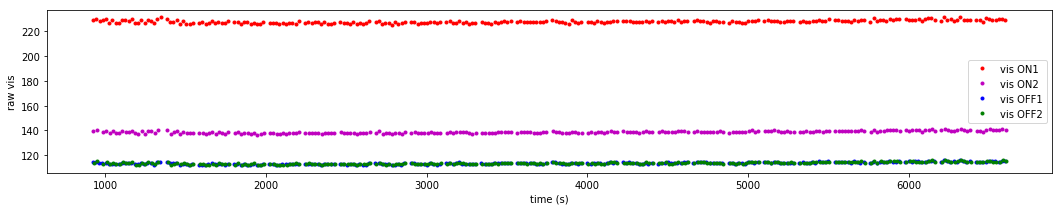

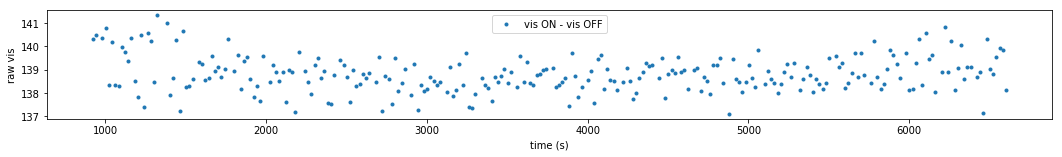

In [96]:
plt.figure(figsize=(18,3))
plt.plot(timestamps[nd_on1]-timestamps[0], vis_clean[nd_on1,ch_plot],'r.')
plt.plot(timestamps[nd_on2]-timestamps[0], vis_clean[nd_on2,ch_plot],'m.')
plt.plot(timestamps[nd_off1]-timestamps[0], vis_clean[nd_off1,ch_plot],'b.')
plt.plot(timestamps[nd_off2]-timestamps[0], vis_clean[nd_off2,ch_plot],'g.')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.legend(['vis ON1', 'vis ON2', 'vis OFF1','vis OFF2'])
plt.show()

plt.figure(figsize=(18,2))
plt.plot(timestamps[nd_on1]-timestamps[0],vis_gap ,'.')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.legend(['vis ON - vis OFF'])
plt.show()

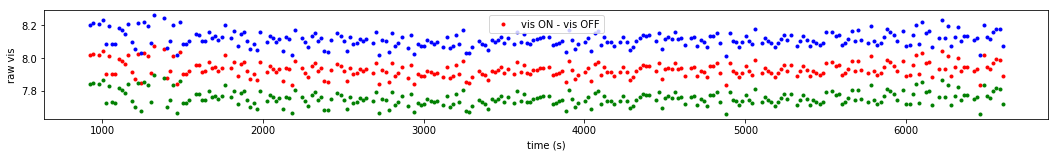

In [97]:
plt.figure(figsize=(18,2))
plt.plot(timestamps[nd_on1]-timestamps[0], g_eq,'r.')
plt.plot(timestamps[nd_on1]-timestamps[0], g_eq1,'b.')
plt.plot(timestamps[nd_on1]-timestamps[0], g_eq2,'g.')
#plt.plot(timestamps[nd_on1]-timestamps[0], g_eq3,'k.')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.legend(['vis ON - vis OFF'])
plt.show()

In [98]:
print Tnd_ref,Tnda,Tndb,Tnd_cal
print ga0,gb0

22.9139464379 19.0073081818 19.8891675967 19.4395865892
8.18184614637 7.55098353831


## Method D:
## the third method BOSS want to try,  similar to Method C but using mean vis in several channels

In [99]:
def vis_clean_band_mean(vis_clean,ch_min,ch_max):
    vis_clean_m=np.ma.array(np.zeros_like(vis_clean[:,0]),mask=True)
    for i in range(np.shape(vis_clean)[0]):
        if (vis_clean[i,ch_min:ch_max].mask==False).all()==True:
            vis_clean_m[i]=np.mean(vis_clean[i,ch_min:ch_max])
        #else:
        #    print str(i) +' masked'
    return vis_clean_m

In [100]:
band_width=30


In [101]:
vis_clean_m=vis_clean_band_mean(vis_clean,ch_plot-band_width/2,ch_plot+band_width/2)

In [102]:
a=np.where(vis_clean_m.mask==False)[0]
print len(a)

3531


In [103]:
vis_gap2=vis_clean_m[nd_on1]+vis_clean_m[nd_on2]-vis_clean_m[nd_off1]-vis_clean_m[nd_off2]
g2_eq=vis_gap2/0.9/Tm
g2_eq1=vis_gap2/0.9/Tnda
g2_eq2=vis_gap2/0.9/Tndb
g2_eq3=vis_gap2/0.9/Tnd_ref

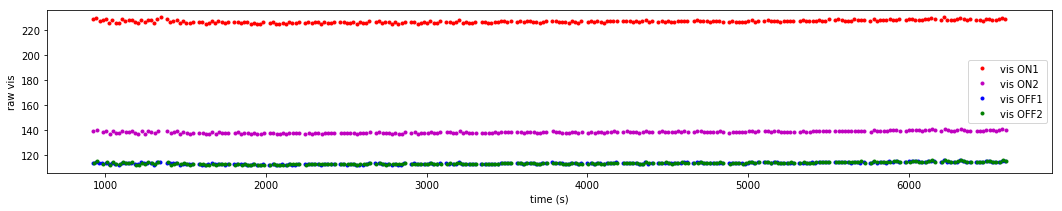

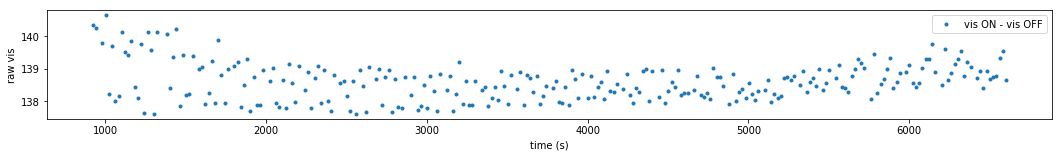

In [104]:
plt.figure(figsize=(18,3))
plt.plot(timestamps[nd_on1]-timestamps[0], vis_clean_m[nd_on1],'r.')
plt.plot(timestamps[nd_on2]-timestamps[0], vis_clean_m[nd_on2],'m.')
plt.plot(timestamps[nd_off1]-timestamps[0], vis_clean_m[nd_off1],'b.')
plt.plot(timestamps[nd_off2]-timestamps[0], vis_clean_m[nd_off2],'g.')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.legend(['vis ON1', 'vis ON2', 'vis OFF1','vis OFF2'])
plt.show()

plt.figure(figsize=(18,2))
plt.plot(timestamps[nd_on1]-timestamps[0],vis_gap2 ,'.')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.legend(['vis ON - vis OFF'])
plt.show()

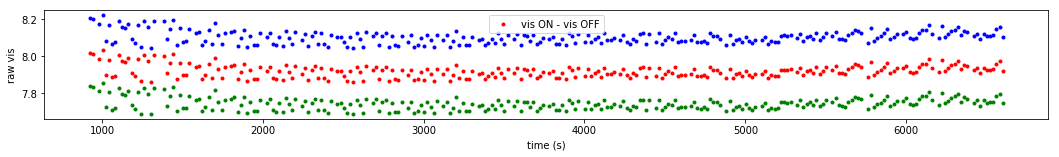

In [105]:
plt.figure(figsize=(18,2))
plt.plot(timestamps[nd_on1]-timestamps[0], g2_eq,'r.')
plt.plot(timestamps[nd_on1]-timestamps[0], g2_eq1,'b.')
plt.plot(timestamps[nd_on1]-timestamps[0], g2_eq2,'g.')
#plt.plot(timestamps[nd_on1]-timestamps[0], g_eq3,'k.')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.legend(['vis ON - vis OFF'])
plt.show()

## Comparison of three methods

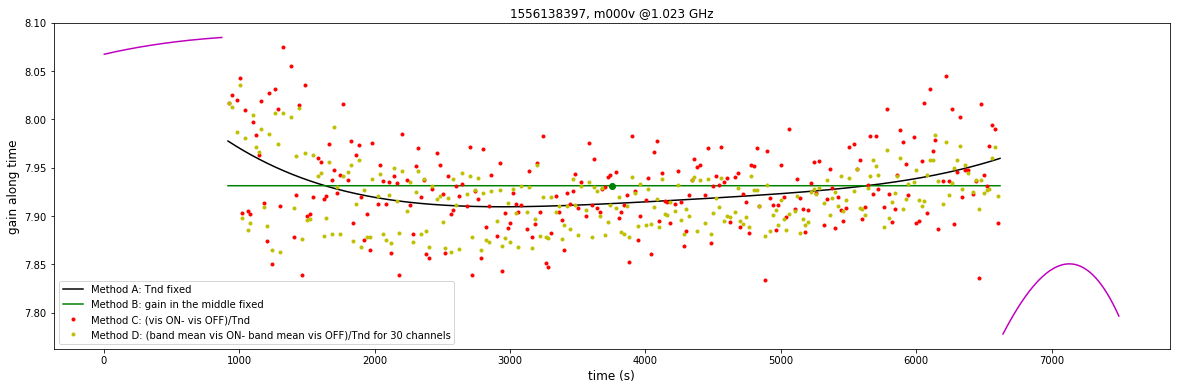

In [106]:


plt.figure(figsize=(20,6))

plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_gt(timestamps,gt1)[dp_sb:dp_se+1],'k')
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],ks.func_gt(timestamps,gt2)[dp_sb:dp_se+1],'g')
plt.plot(timestamps[nd_on1]-timestamps[0], g_eq,'r.')
plt.plot(timestamps[nd_on1]-timestamps[0], g2_eq,'y.')
plt.plot(timestamps[dp_m]-timestamps[0],(gb+ge)/2.,'go')
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca],'m')
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb],'m')
#plt.plot(timestamps[nd_on1]-timestamps[0], g_eq1,'b.')
#plt.plot(timestamps[nd_on1]-timestamps[0], g_eq2,'g.')

plt.xlabel('time (s)',fontsize=12)
plt.ylabel('gain along time',fontsize=12)
plt.title(str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.legend(['Method A: Tnd fixed','Method B: gain in the middle fixed', 'Method C: (vis ON- vis OFF)/Tnd', 'Method D: (band mean vis ON- band mean vis OFF)/Tnd for '+str(band_width)+' channels'])
plt.show()

In [107]:
t2=time.time()
print t2-t1

241.972615004


In [108]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Mon Dec 23 15:57:18 2019#
